In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.neighbors import NearestNeighbors
from skopt import expected_minimum, load
from skopt.learning.gaussian_process.kernels import RBF, WhiteKernel
import random
import obspy.geodetics as gd
import os

## Generating input files and batch scripts

In [2]:
def gen_sensor_arr(fidelity):
    """
    Function that generates a grid array of sensors in the domain [40,42] X [-112, -108.38] with the desired fidelity value
    
    Inputs
    ------
    fidelity (float) : desired sensor fidelity
    
    Returns
    -------
    sensors (np.array) : grid array of sensors with desired fidelity value
    """
    sensors = np.array([[41.,-110.19,fidelity,2.,0.],
                        [41.,-109.19,fidelity,2.,0.],
                        [41.,-111.19,fidelity,2.,0.],
                        [41.5,-110.19,fidelity,2.,0.],
                        [41.5,-109.19,fidelity,2.,0.],
                        [41.5,-111.19,fidelity,2.,0.],
                        [40.5,-110.19,fidelity,2.,0.],
                        [40.5,-109.19,fidelity,2.,0.],
                        [40.5,-111.19,fidelity,2.,0.]])
    
    return sensors

def write_input_file(file, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, mag_range, sensors, sampling_file):
    """
    Writes an input file for eig_calc.py using the specified function parameters
    
    Inputs
    ------
    file          (str) : filename of input file (with .dat file extension)
    nlpts_data    (int) : number of synthetic events to generate
    nlpts_space   (int) : number of points to use in space discretization
    ndata         (int) : number of data realizations based on synthetic events to generate
    lat_range     (np.array) : tuple specifying latitude range to consider in analysis
    long_range    (np.array) : tuple specifying longitude range to consider in analysis
    depth_range   (np.array) : tuple specifying depth range to consider in analysis
    mag_range     (np.array) : tuple specifying magnitude range to consider in analysis
    sensors       (np.array) : array of sensors
    sampling_file (str) : name of file where prior and importance distribution sampling functions are stored.
                          Should be same directory as eig_calc.py otherwise problems will occur.
                          Currently equires a newline delimiter at the end of the str or the script will throw errors.
    
    Returns
    -------
    Writes input file to working directory with name {file}
    """
    writedata=open(file,"w+")
    writedata.write(str(np.int(nlpts_data)) + "\n")
    writedata.write(str(np.int(nlpts_space)) + "\n")
    writedata.write(str(np.int(ndata)) + "\n")
    
    #,max_line_width=1000 to keep numppy from splitting the sensor description up onto multiple lines.
    writedata.write((np.array2string(lat_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(long_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(depth_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(mag_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")

    # Write file to sample with
    sampling_file = writedata.write(sampling_file)
    
    #rest of lines are sensors
    writedata.write((np.array2string(sensors,separator=',',max_line_width=1000)).replace('[','').replace('],','').replace(']','').replace(' ', '') + "\n")

    #lat, long, measurement noise std, length of data vector for sensor, sensor type
    #write teh new sensor
    
    writedata.close()
    return
def gen_slurmstr_std(in_path, out_path, nodes=8, cores=32):
    """
    Writes slurm batch file to working directory (should be same directory as eig_calc.py) 
    that runs eig_calc with the specified input and output files.
    
    Inputs
    ------
    in_path  (str) : path to eig_calc.py input file (should be .dat file)
    out_path (str) : desired path for eig_calc.py to save outputs (should be .npz file)
    nodes    (int) : number of desired nodes to use for running job
    cores    (cores) : number of cores each node should use for running job
    
    Returns
    -------
    out_path (str) : 
    """
    
    return f"""#!/bin/bash
## Do not put any commands or blank lines before the #SBATCH lines
#SBATCH --nodes={nodes}                   # Number of nodes - all cores per node are allocated to the job
#SBATCH --time=02:00:00              # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
#SBATCH --account=FY210056           # WC ID
#SBATCH --job-name=fidel_{i}          # Name of job
#SBATCH --partition=short,batch            # partition/queue name: short or batch
                                      #            short: 4hrs wallclock limit
                                      #            batch: nodes reserved for > 4hrs (default)
#SBATCH --qos=normal                  # Quality of Service: long, large, priority or normal
                                      #           normal: request up to 48hrs wallclock (default)
                                      #           long:   request up to 96hrs wallclock and no larger than 64nodes
                                      #           large:  greater than 50% of cluster (special request)
                                      #           priority: High priority jobs (special request)
#SBATCH --export=ALL                 # export environment variables form the submission env (modules, bashrc etc)

nodes=$SLURM_JOB_NUM_NODES           # Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
cores={cores}                             # Number MPI processes to run on each node (a.k.a. PPN)
                                     # CTS1 has 36 cores per node, skybridge 16

mpiexec --bind-to core --npernode $cores --n $(($cores*$nodes)) python3 -u std_calc.py {in_path} {out_path} 1
    """

def gen_slurmstr_eig(in_path, out_path, nodes=8, cores=32):
    """
    Writes slurm batch file to working directory (should be same directory as eig_calc.py) 
    that runs eig_calc with the specified input and output files.
    
    Inputs
    ------
    in_path  (str) : path to eig_calc.py input file (should be .dat file)
    out_path (str) : desired path for eig_calc.py to save outputs (should be .npz file)
    nodes    (int) : number of desired nodes to use for running job
    cores    (cores) : number of cores each node should use for running job
    
    Returns
    -------
    out_path (str) : 
    """
    
    return f"""#!/bin/bash
## Do not put any commands or blank lines before the #SBATCH lines
#SBATCH --nodes={nodes}                   # Number of nodes - all cores per node are allocated to the job
#SBATCH --time=03:00:00              # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
#SBATCH --account=FY210056           # WC ID
#SBATCH --job-name=fidel_{i}          # Name of job
#SBATCH --partition=short,batch            # partition/queue name: short or batch
                                      #            short: 4hrs wallclock limit
                                      #            batch: nodes reserved for > 4hrs (default)
#SBATCH --qos=normal                  # Quality of Service: long, large, priority or normal
                                      #           normal: request up to 48hrs wallclock (default)
                                      #           long:   request up to 96hrs wallclock and no larger than 64nodes
                                      #           large:  greater than 50% of cluster (special request)
                                      #           priority: High priority jobs (special request)
#SBATCH --export=ALL                 # export environment variables form the submission env (modules, bashrc etc)

nodes=$SLURM_JOB_NUM_NODES           # Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
cores={cores}                             # Number MPI processes to run on each node (a.k.a. PPN)
                                     # CTS1 has 36 cores per node, skybridge 16

mpiexec --bind-to core --npernode $cores --n $(($cores*$nodes)) python3 -u eig_calc.py {in_path} {out_path} 1
    """

def gen_slurmstr_opt(in_path, out_path, nodes=8, cores=32):
    """
    Writes slurm batch file to working directory (should be same directory as eig_calc.py) 
    that runs eig_calc with the specified input and output files.
    
    Inputs
    ------
    in_path  (str) : path to eig_calc.py input file (should be .dat file)
    out_path (str) : desired path for eig_calc.py to save outputs (should be .npz file)
    nodes    (int) : number of desired nodes to use for running job
    cores    (cores) : number of cores each node should use for running job
    
    Returns
    -------
    out_path (str) : 
    """
    
    return f"""#!/bin/bash
## Do not put any commands or blank lines before the #SBATCH lines
#SBATCH --nodes={nodes}                   # Number of nodes - all cores per node are allocated to the job
#SBATCH --time=03:00:00              # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
#SBATCH --account=FY210056           # WC ID
#SBATCH --job-name=fidel_{i}          # Name of job
#SBATCH --partition=short,batch            # partition/queue name: short or batch
                                      #            short: 4hrs wallclock limit
                                      #            batch: nodes reserved for > 4hrs (default)
#SBATCH --qos=normal                  # Quality of Service: long, large, priority or normal
                                      #           normal: request up to 48hrs wallclock (default)
                                      #           long:   request up to 96hrs wallclock and no larger than 64nodes
                                      #           large:  greater than 50% of cluster (special request)
                                      #           priority: High priority jobs (special request)
#SBATCH --export=ALL                 # export environment variables form the submission env (modules, bashrc etc)

nodes=$SLURM_JOB_NUM_NODES           # Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
cores={cores}                             # Number MPI processes to run on each node (a.k.a. PPN)
                                     # CTS1 has 36 cores per node, skybridge 16

mpiexec --bind-to core --npernode $cores --n $(($cores*$nodes)) python3 -u eig_calc.py {in_path} {out_path} 1
    """

# Write 21 input files and slurm execution scripts with fidelities in between -5 and 5
# for i in np.linspace(-3,3.5,12):
#     sensors = gen_sensor_arr(i)
#     it = str(np.round(i,2)).replace('.','_')
#     in_path = f'final_fid_prior/eig_inputs_{it}.dat'
#     out_path = f'/gpfs/jpcalla/final_fid_prior/eig_{it}.npz'
    
#     write_input_file(in_path, 
#                      4096, 
#                      16384, 
#                      16, 
#                      np.array([40,42]), 
#                      np.array([-112, -108.38]),
#                      np.array([0,40]),
#                      np.array([.5,10]),
#                      sensors,
#                      'sample_gen.py\n')
#     slurm_str = gen_slurmstr_eig(in_path, out_path,cores=16)
#     with open(f'eigbatch_{it}.bash', 'w+') as f:
#         f.write(slurm_str)
    
#     with open('eig_runs.bash', 'a+')as f:
#         f.write(f'sbatch eigbatch_{it}.bash\n')
for i in ['-1_5', '0', '0_5', '2']:
    num = i.strip('-')
    fpath = f'/gpfs/jpcalla/fidopt_{i}'
    sensors = np.load(os.path.join(fpath,f'{num}_net.npz'))['sensors']
    in_path = os.path.join(fpath,f'std_inputs_{i}.dat')
    out_path = os.path.join(fpath,f'std_{i}.npz')
    
    write_input_file(in_path, 
                     4096, 
                     16384, 
                     16, 
                     np.array([40,42]), 
                     np.array([-112, -108.38]),
                     np.array([0,40]),
                     np.array([.5,10]),
                     sensors,
                     'unif_prior.py\n')
    slurm_str = gen_slurmstr_std(in_path, out_path,cores=32)
    with open(f'stdbatch_{i}.bash', 'w+') as f:
        f.write(slurm_str)
    
    with open('std_runs.bash', 'a+')as f:
        f.write(f'sbatch stdbatch_{i}.bash\n')


## Visualizing eig_calc outputs

In [3]:
# Analysis domains
lat_range = [40,42]
long_range = [-112,-108.38]
mag_range = [.5,10]
depth_range = [0,40]

### Information gain surface as affected by sensor fidelity

We investigate the effect of sensor fidelity on information gain. We control the fidelity of a given sensor by adding an offset to its ratio of signal to measurement noise, an offset than can be thought of as corresponding to measurement noise with a given standard deviation. We examine the effect of fidelity by comparing the information gain surface generated by a grid of 9 evenly spaced sensors across 12 different signal-to-measurement noise ratio offsets. In this experiment, these evenly spaced offets range from -3.0 to 3.5. We perform this experiment using both a uniform prior on events and the non-uniform fault-box prior. The results of these experiments can be seen in Figures **TODO** and **TODO**.  As when controlling the measurement noise standard deviation directly, we see that below a certain fidelity offset value the measurement noise dominates the signal and as such we see minimal information gain. Once past a certain threshold (in this case a sensor fidelity of -.045 corresponding to a measurement noise standard deviation of 1.59) the model uncertainty begins to take over and we see an increase in information gain in both the uniform and non-uniform prior cases.

In [4]:
def select_training_samples(samples, targets, depth_slice=0, mag_slice=.5, depth_tol=5, mag_tol=1,method='tol', verbose=1):
    if method=='tol':
        depth_low = depth_slice - depth_tol
        depth_high = depth_slice + depth_tol

        mag_low = mag_slice - mag_tol
        mag_high = mag_slice + mag_tol

        # Mask that selects samples whose magnitude and depth are in the desired range
        mask = [((samples[:,2]<=depth_high) & (samples[:,2]>=depth_low)) & 
                ((samples[:,3]<=mag_high) & (samples[:,3]>=mag_low))]

        training_inputs = samples[tuple(mask)]
        training_targets = targets[tuple(mask)]
        if verbose==1:
            print(f'Selected {training_inputs.shape[0]} samples to train with')
        
    elif method=='random':
        idx = random.sample(range(0,len(samples)), 1000)
        training_inputs = samples[idx]
        training_targets = targets[idx]

    return training_inputs, training_targets

# List to store eig values
eigs = []
stds =[] 
nums = np.linspace(-3.,3.5,12)
# nums = ['-5', '-38', '-27', '-16', '-06', '06', '16', '27', '38', '5']
fig, axs = plt.subplots(3,4,figsize=(36,24), dpi=300)
# nums = ['38', '5']

# Loop through each output file (filenames and loop values will need to change for different analyes)
for i, fid in enumerate(nums):
    # Load data
    it = str(np.round(fid,2)).replace('.','_')
    std = np.load(f'/gpfs/jpcalla/final_fid/std_{it}.npz')['measnoise'].mean()
    res = np.load(f'/gpfs/jpcalla/final_fid/outputs_{it}.npz')
    # Pull out information gains from each synthetic event
    ig = res['ig'].reshape((4096,16)).mean(axis=1)
    # Pull out sensor network used in analysis
    net = res['sensors'][:,:2]
    # Store eig result of analysis
    eigs.append(res['eig'])
    stds.append(std)

    # Gaussian process model to generate ig surface
    kernel = 1.0 * RBF(length_scale=[1.0, 1.0,1.0,1.0], length_scale_bounds=(0.2, 1)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 5e-1))
    model = GPR(kernel=kernel,alpha=0.0, normalize_y=True)
    training_samples, training_targets = select_training_samples(res['theta_data'], ig, method='tol',verbose=0)
    model.fit(training_samples, training_targets)

    # Meshgrid that covers the whole domain to use for surface prediction lat/long inputs
    x = np.linspace(lat_range[0], lat_range[1])
    y = np.linspace(long_range[0], long_range[1])
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.ravel(), yv.ravel()]).T

    # Fill in desired depth and magnitude constants to predict on
    domain = np.zeros((len(xy),4))
    domain[:,:2] = xy
    domain[:,2] = 0
    domain[:,3] = .5

    # Make ig predictions for surface visualization
    preds = model.predict(domain)
    # Plot
    ax = axs[i//4, i%4]
    im = ax.pcolormesh(yv, xv, preds.reshape((50, 50)),
                shading='auto', cmap='jet')
    
    # Plot decorations
    im.set_clim(0,9) # Standardize colorbar limits
    ax.scatter(net[:9,1],net[:9,0],c='white', label='sensors') # Plot sensors
    ax.set_title(f'$\sigma$={np.round(std,2)} (sensor fidelity of {np.round(fid,3)})', size=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
#     if i//3 == 3:
#         ax.set_xlabel('Longitude', size=19)
#     if i%3==0:
#         ax.set_ylabel('Latitude', size=19)
    cbar = fig.colorbar(im, ax = ax)
    cbar.ax.tick_params(labelsize=20)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=.15)
# plt.tight_layout()
plt.savefig('fidelity_grid_uniform.png',dpi=300)
plt.show()

In [5]:
unif_eigs = np.copy(eigs)

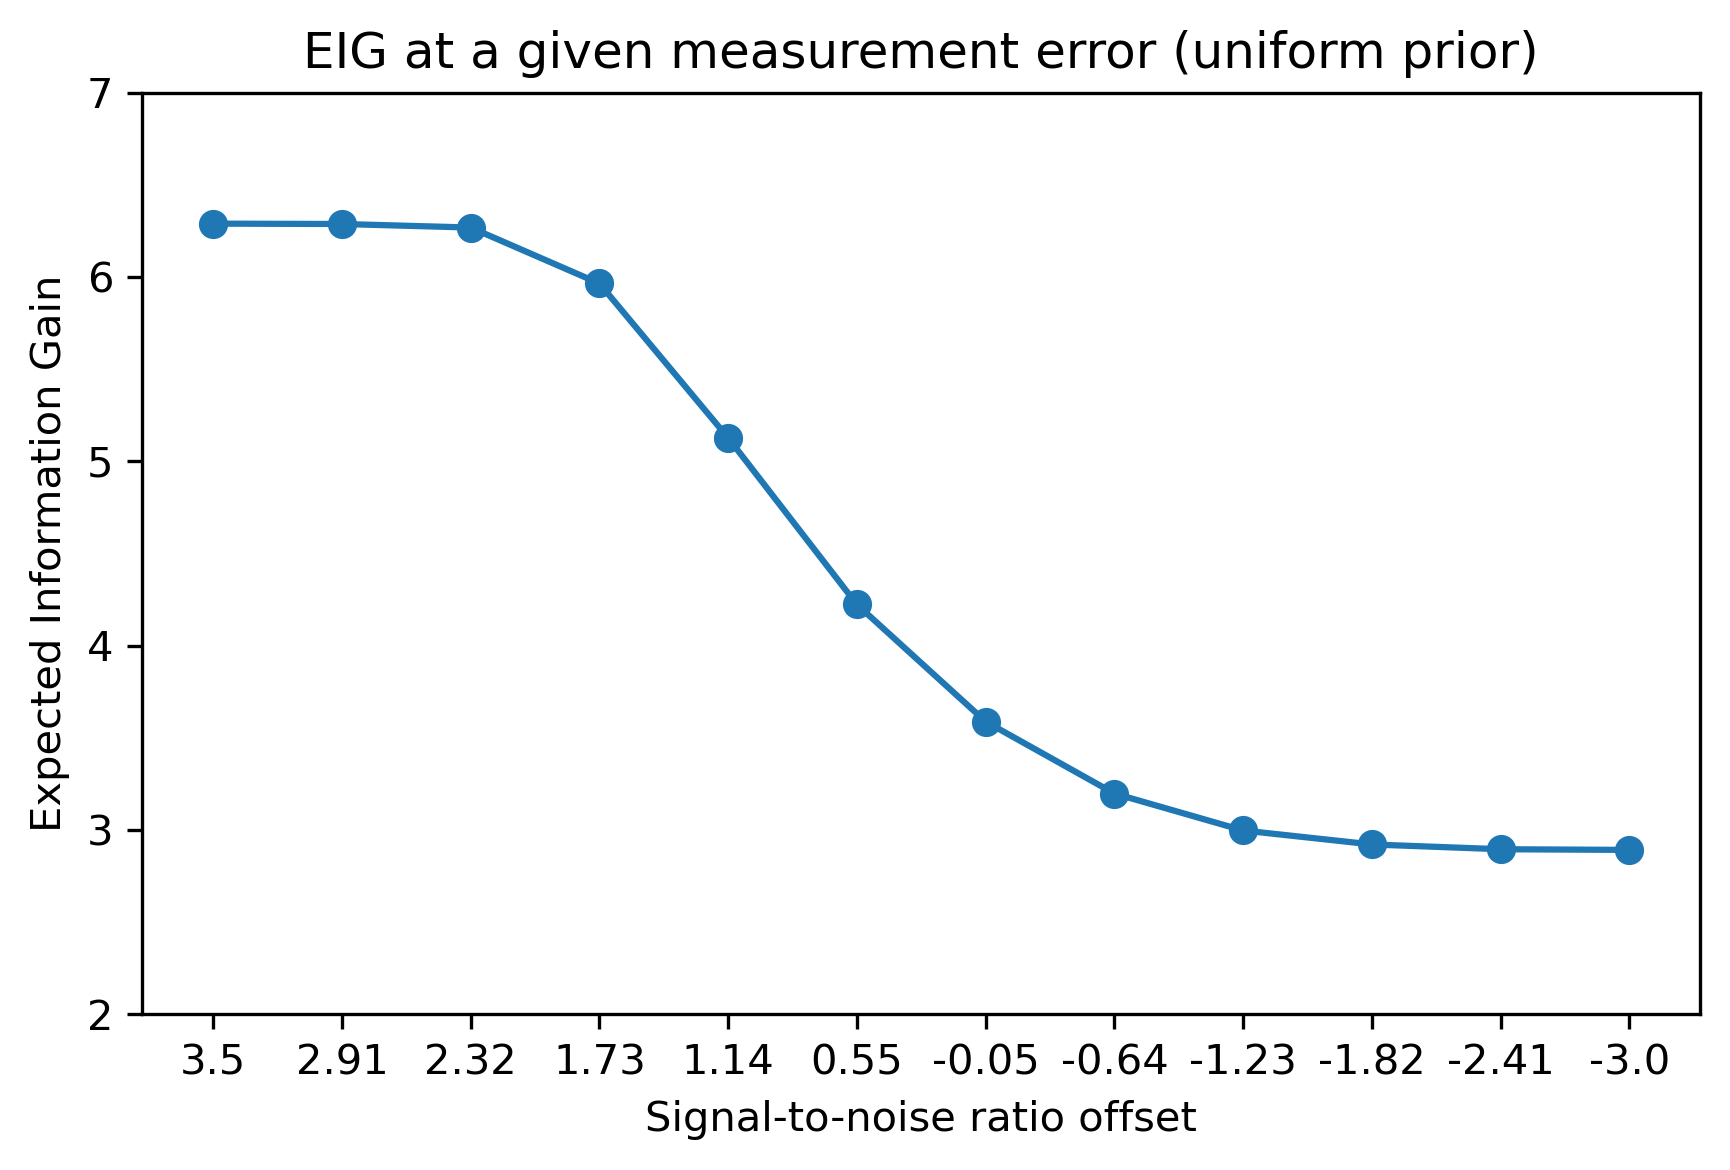

In [18]:
plt.figure(dpi=300)
plt.plot(-1*nums, unif_eigs,marker='o')
plt.xticks(ticks = -1*nums, labels=np.round(nums,2))
plt.title('EIG at a given measurement error (uniform prior)')
plt.xlabel('Signal-to-noise ratio offset')
plt.ylabel('Expected Information Gain')
plt.tight_layout()
plt.ylim(2,7)
plt.savefig('eig_curve_uniform.pdf')
plt.show()

Illustration of the effects of changing the sensor fidelity. 

In [14]:
for i in range(12):
    print(i%3)

0
1
2
0
1
2
0
1
2
0
1
2


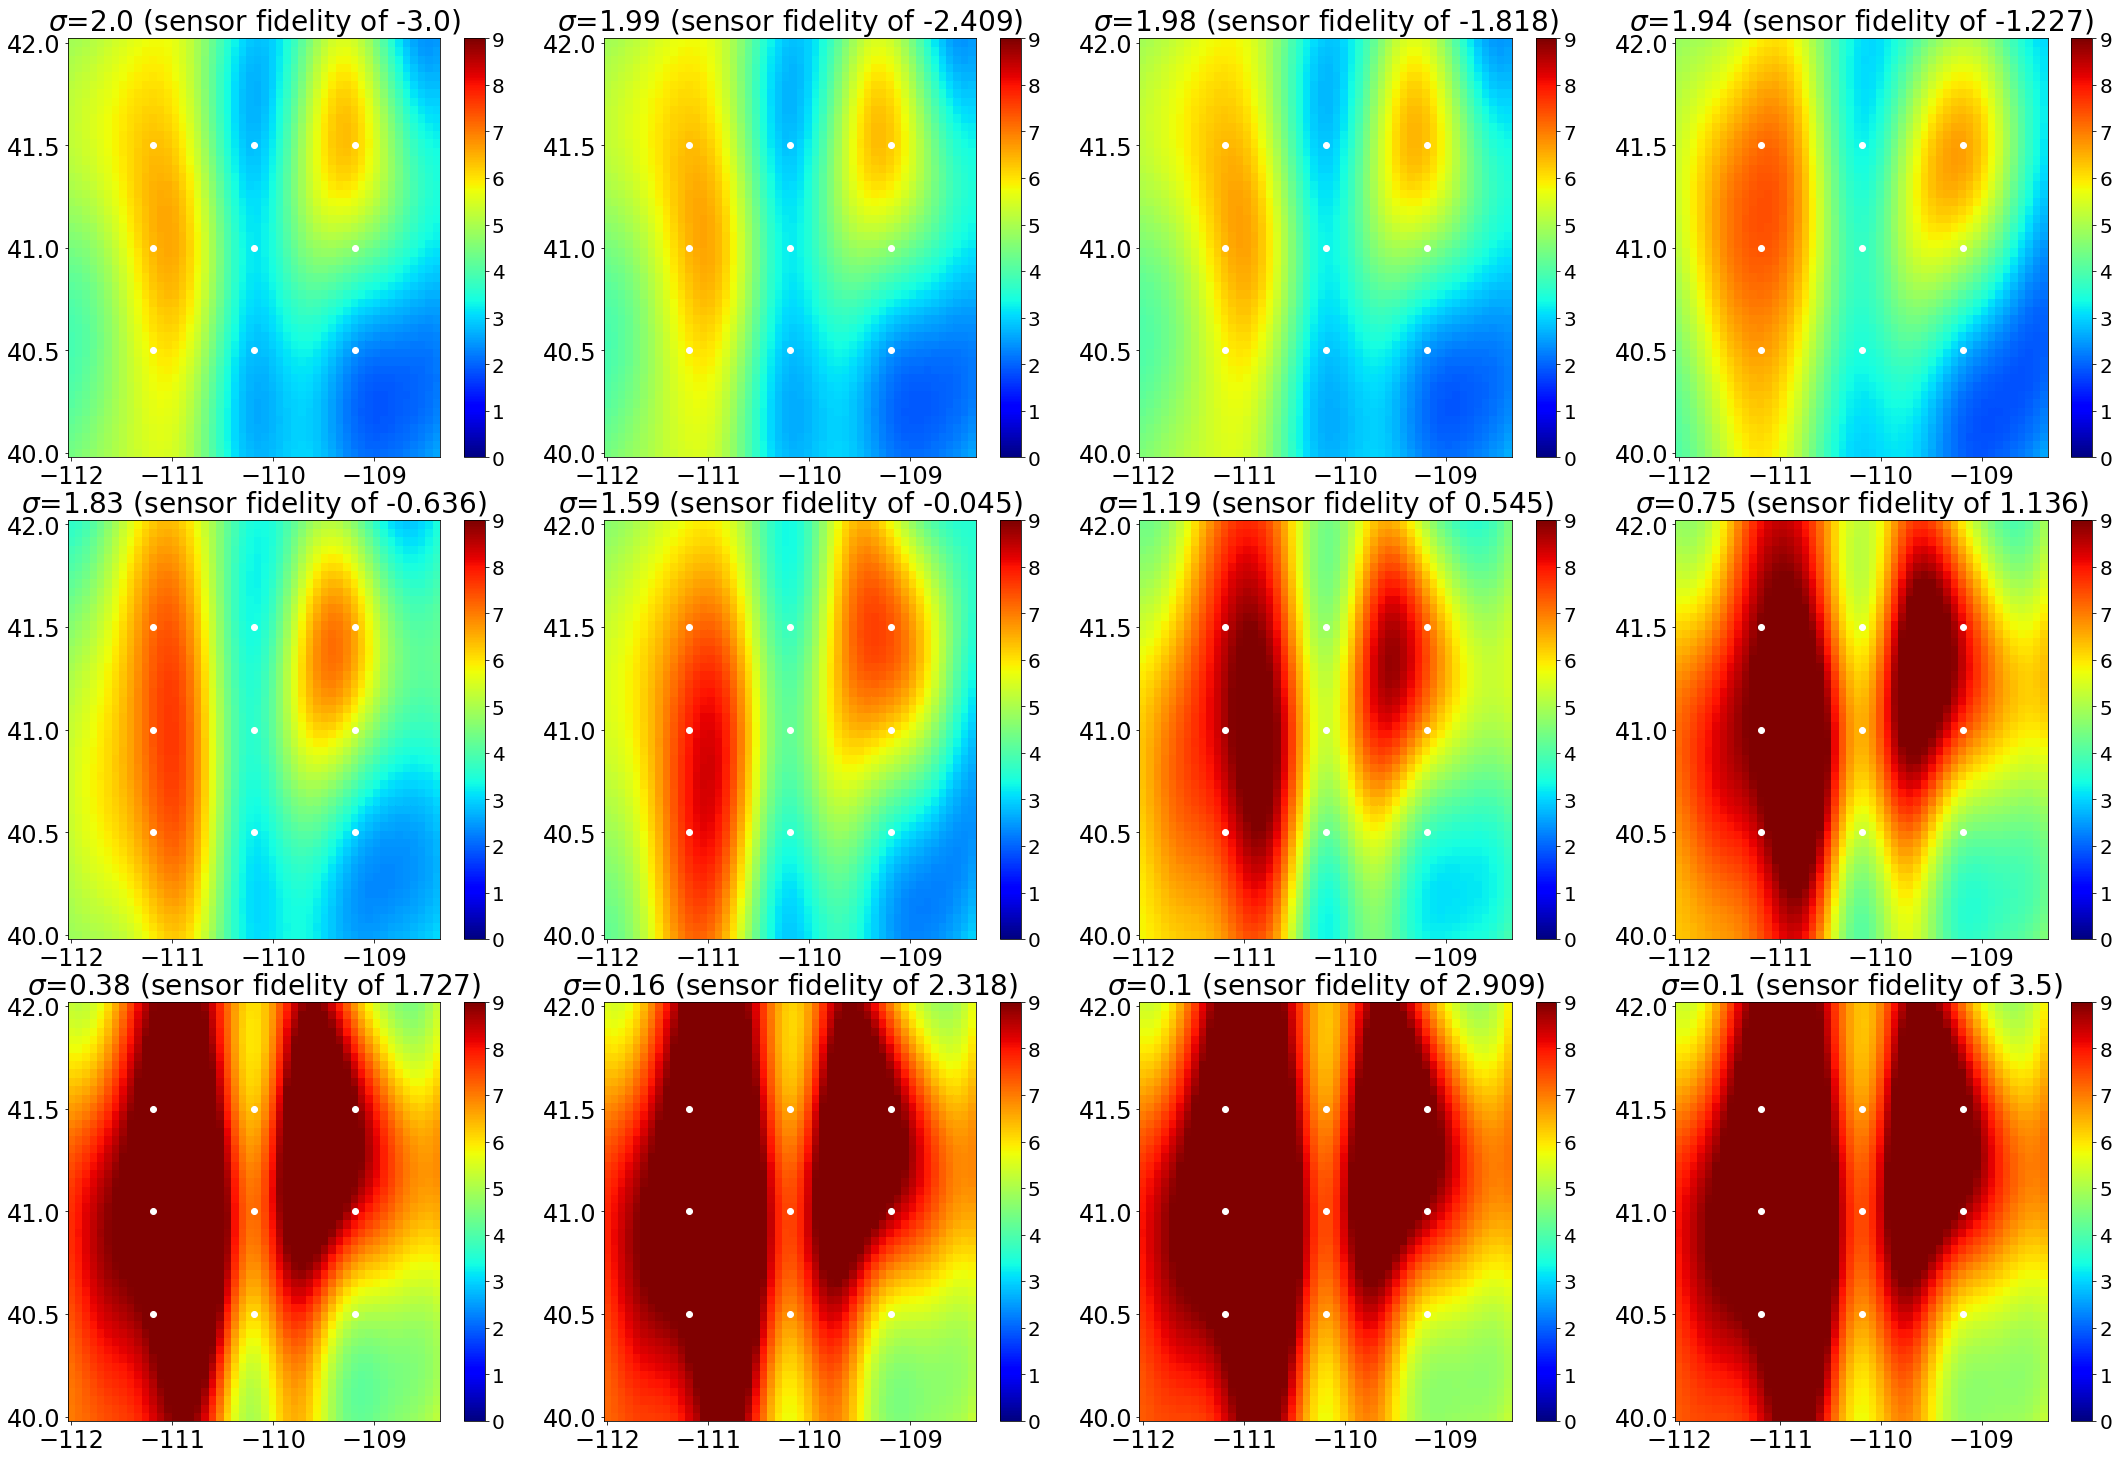

In [7]:
def select_training_samples(samples, targets, depth_slice=0, mag_slice=.5, depth_tol=5, mag_tol=1,method='tol', verbose=1):
    if method=='tol':
        depth_low = depth_slice - depth_tol
        depth_high = depth_slice + depth_tol

        mag_low = mag_slice - mag_tol
        mag_high = mag_slice + mag_tol

        # Mask that selects samples whose magnitude and depth are in the desired range
        mask = [((samples[:,2]<=depth_high) & (samples[:,2]>=depth_low)) & 
                ((samples[:,3]<=mag_high) & (samples[:,3]>=mag_low))]

        training_inputs = samples[tuple(mask)]
        training_targets = targets[tuple(mask)]
        if verbose==1:
            print(f'Selected {training_inputs.shape[0]} samples to train with')
        
    elif method=='random':
        idx = random.sample(range(0,len(samples)), 1000)
        training_inputs = samples[idx]
        training_targets = targets[idx]

    return training_inputs, training_targets

# List to store eig values
eigs = []
nums = np.linspace(-3.,3.5,12)
# nums = ['-5', '-38', '-27', '-16', '-06', '06', '16', '27', '38', '5']
fig, axs = plt.subplots(3,4,figsize=(36,24))
# nums = ['38', '5']

# Loop through each output file (filenames and loop values will need to change for different analyes)
for i, fid in enumerate(nums):
    # Load data
    it = str(np.round(fid,2)).replace('.','_')
    std = np.load(f'/gpfs/jpcalla/final_fid/std_{it}.npz')['measnoise'].mean()
    res = np.load(f'/gpfs/jpcalla/final_fid_prior/eig_{it}.npz')
    # Pull out information gains from each synthetic event
    ig = res['ig'].reshape((4096,16)).mean(axis=1)
    # Pull out sensor network used in analysis
    net = res['sensors'][:,:2]
    # Store eig result of analysis
    eigs.append(res['eig'])

    # Gaussian process model to generate ig surface
    kernel = 1.0 * RBF(length_scale=[1.0, 1.0,1.0,1.0], length_scale_bounds=(0.2, 1)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 5e-1))
    model = GPR(kernel=kernel,alpha=0.0, normalize_y=True)
    training_samples, training_targets = select_training_samples(res['theta_data'], ig, method='tol',verbose=0)
    model.fit(training_samples, training_targets)

    # Meshgrid that covers the whole domain to use for surface prediction lat/long inputs
    x = np.linspace(lat_range[0], lat_range[1])
    y = np.linspace(long_range[0], long_range[1])
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.ravel(), yv.ravel()]).T

    # Fill in desired depth and magnitude constants to predict on
    domain = np.zeros((len(xy),4))
    domain[:,:2] = xy
    domain[:,2] = 0
    domain[:,3] = .5

    # Make ig predictions for surface visualization
    preds = model.predict(domain)
    # Plot
    ax = axs[i//4, i%4]
    im = ax.pcolormesh(yv, xv, preds.reshape((50, 50)),
                shading='auto', cmap='jet')
    
    # Plot decorations
    im.set_clim(0,9) # Standardize colorbar limits
    ax.scatter(net[:9,1],net[:9,0],c='white', label='sensors') # Plot sensors
    ax.set_title(f'$\sigma$={np.round(std,2)} (sensor fidelity of {np.round(fid,3)})', size=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
#     ax.set_xlabel('Longitude', size=19)
#     ax.set_ylabel('Latitude', size=19)
    cbar = fig.colorbar(im, ax = ax)
    cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=.15)
plt.savefig('fidelity_grid_faultbox.png',dpi=300)
plt.show()

In [13]:
nums

array([-3.        , -2.40909091, -1.81818182, -1.22727273, -0.63636364,
       -0.04545455,  0.54545455,  1.13636364,  1.72727273,  2.31818182,
        2.90909091,  3.5       ])

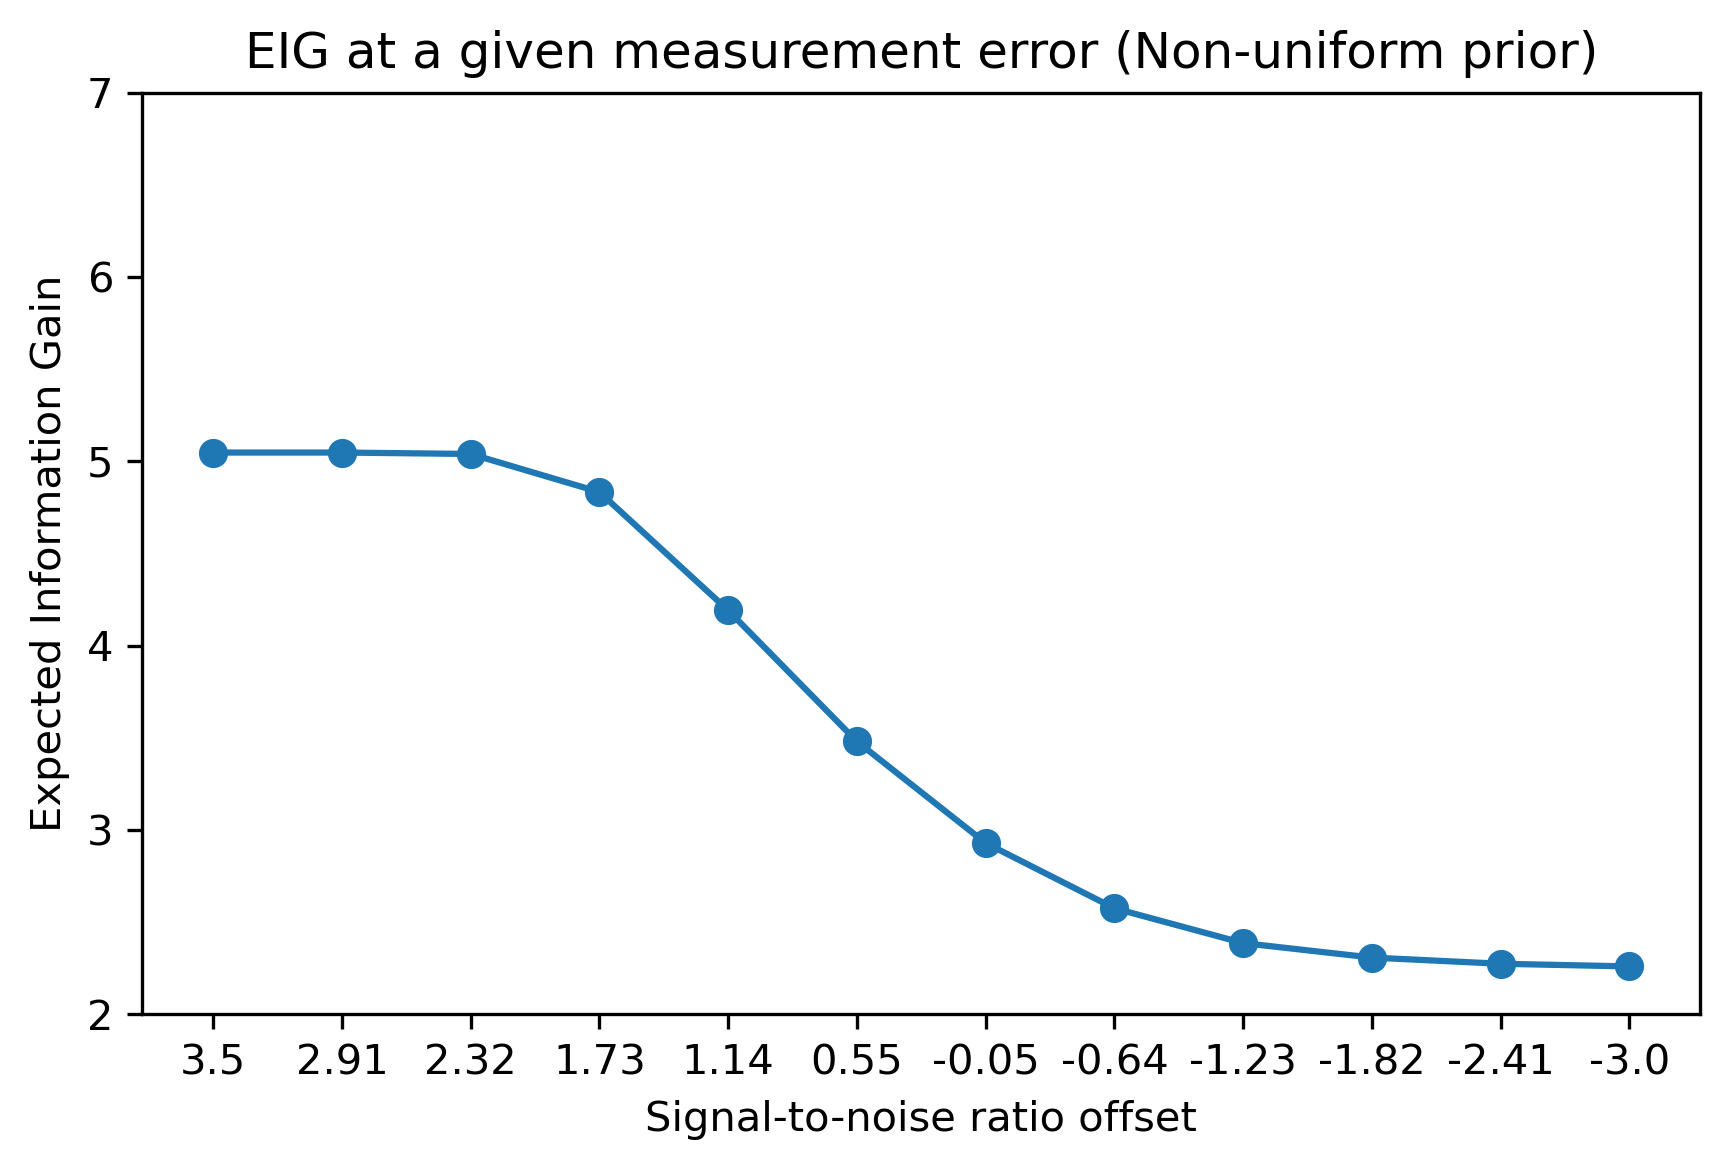

In [19]:
plt.figure(dpi=300)
plt.plot(-1*nums, eigs,marker='o')
plt.xticks(ticks = -1*nums, labels=np.round(nums,2))
plt.title('EIG at a given measurement error (Non-uniform prior)')
plt.xlabel('Signal-to-noise ratio offset')
plt.ylabel('Expected Information Gain')
plt.tight_layout()
plt.savefig('eig_curve_faultbox.pdf')
plt.ylim(2,7)
plt.show()

### EIG and sensor closeness by number of sensors 
We next investigate how sensor placement is affected by varying sensor fidelity conditions. Using both the uniform and non-uniform fault-box prior, we place 20 sensors using four different sensor fidelity values. Unsurprisingly, we see that as sensor fidelity increases, the network's information gain also increases. It is difficult to see a clear pattern in sensor proximity, but we notice that as sensor fidelity increases, sensors are generally placed closer together. This could be due to the fact that noisy sensors need to be plaed farther apart from each other than less noisy sensors in order to properly triangulate events.

In [130]:
res = np.load('/gpfs/jpcalla/fidopt_0_5/result_eigdata2.npz')
locs = res['sensors'][:,:2]
nn = NearestNeighbors().fit(locs)
locs
# _, idxs = nn.kneighbors(n_neighbors=1)
# dists = []
# for i, idx in enumerate(idxs):
#     lat1,lon1 = locs[i]f
#     lat2, lon2 = locs[idx[0]]
#     dist = gd.degrees2kilometers(gd.locations2degrees(lat1,lon1,lat2,lon2))
#     dists.append(dist)
# np.mean(dists)

array([[  41.5 , -110.19]])

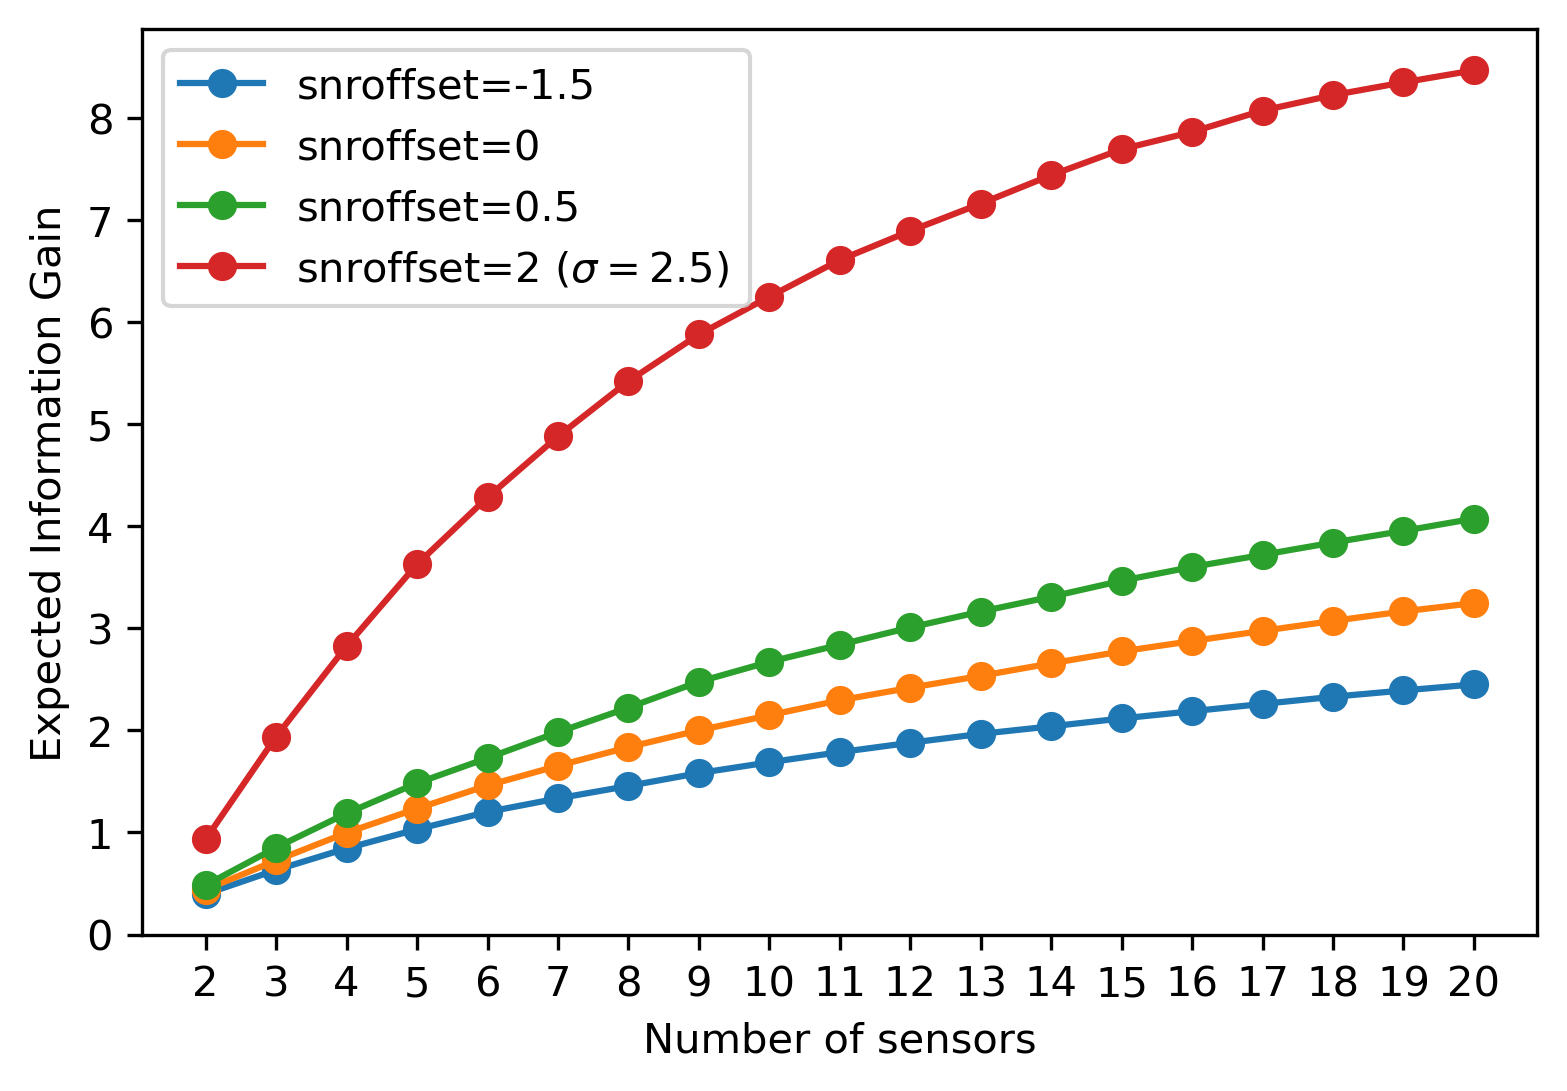

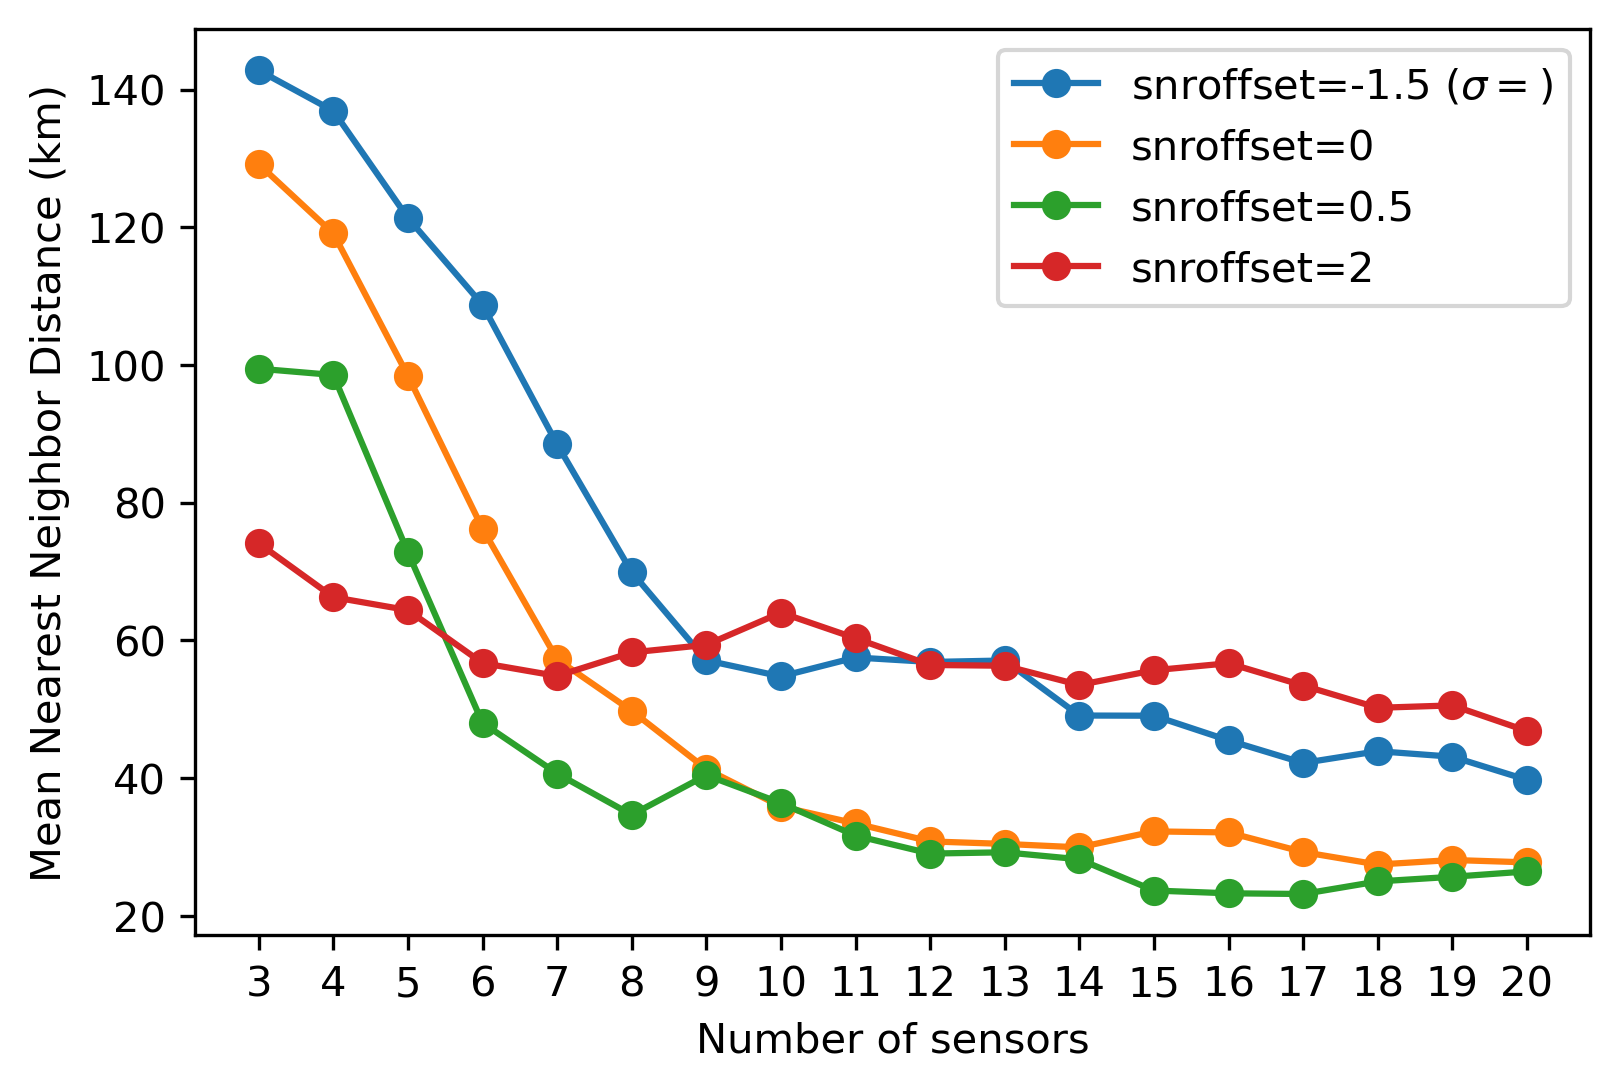

In [30]:
thomas_path = '/ascldap/users/tacatan/hpc_home/seismic_oed'
def get_eig_nn(fpath,frange, range_max = None):
    if not range_max:
        range_max = frange
        
    eigs = []
    igs = []
    dists = []
    
    for i in range(3,range_max):
        if i >= frange:
            igs.append(0)
            eigs.append(eigs[-1])
        else:
            newpath = f'{fpath}/result_eigdata{i}.npz'
            res = np.load(newpath)
            ig = res['eigdata_full'][:,0]
            eig = np.max(ig) # store eig
            igs.append(ig)
            eigs.append(eig)

        # Calculate and store mean nearest neighbor distance when possible
        if i >= frange:
            dists.append(dists[-1])
        else:
            if i>3:
                locs = res['sensors'][:,:2]
                nn = NearestNeighbors().fit(locs)
                _, idxs = nn.kneighbors(n_neighbors=1)

                point_dists = []
                for j, idx in enumerate(idxs):
                    lat1,lon1 = locs[j]
                    lat2, lon2 = locs[idx[0]]
                    dist = gd.degrees2kilometers(gd.locations2degrees(lat1,lon1,lat2,lon2))
                    point_dists.append(dist)
                dists.append(np.mean(point_dists))

    return eigs, igs, dists

eigs15, igs15, dists15 = get_eig_nn('/gpfs/jpcalla/fidopt_-1_5',22,22)
eigs05, igs05, dists05 = get_eig_nn('/gpfs/jpcalla/fidopt_0_5',22, 22)
eigs2, igs2, dists2 = get_eig_nn('/gpfs/jpcalla/fidopt_2',22, 22)
eigs0, igs0, dists0 = get_eig_nn('/gpfs/jpcalla/fidopt_0',22, 22)
# Store eigs from 3 different runs

  
        
# Plot eig by number of sensors
plt.figure(dpi=300)
plt.plot(np.arange(2,21),eigs15,marker='o', label='snroffset=-1.5')
plt.plot(np.arange(2,21),eigs0,marker='o', label='snroffset=0')
plt.plot(np.arange(2,21),eigs05,marker='o', label='snroffset=0.5')
plt.plot(np.arange(2,21),eigs2,marker='o', label='snroffset=2 ($\sigma=2.5$) ')
plt.xlabel('Number of sensors')
plt.ylabel('Expected Information Gain')
plt.legend(loc='upper left')
plt.xticks(np.arange(2,21))
plt.savefig('fid_curves.pdf', dpi=300)
plt.show()

# Plot mean nearest neighbor distance by number of sensors
plt.figure(dpi=300)
plt.plot(np.arange(3,21),dists15,marker='o',label='snroffset=-1.5 ($\sigma=$)')
plt.plot(np.arange(3,21),dists0,marker='o', label='snroffset=0')
plt.plot(np.arange(3,21),dists05,marker='o', label='snroffset=0.5')
plt.plot(np.arange(3,21),dists2,marker='o', label='snroffset=2')

#plt.plot(np.arange(3,13),low_dists,marker='o', label='constant std of 10')
plt.xlabel('Number of sensors')
plt.ylabel('Mean Nearest Neighbor Distance (km)')
plt.legend(loc='upper right')
plt.xticks(np.arange(3,21))
plt.savefig('distance_curves.pdf', dpi=300)
plt.show()

In [6]:
sensors14 = np.load('/gpfs/jpcalla/lscal_14/lscal_14.npz')['sensors']
sensors147 = np.load('/gpfs/jpcalla/lscal_147/lscal_147.npz')['sensors']
sensors1475 = np.load('/gpfs/jpcalla/lscal_1475/lscal_1475.npz')['sensors']

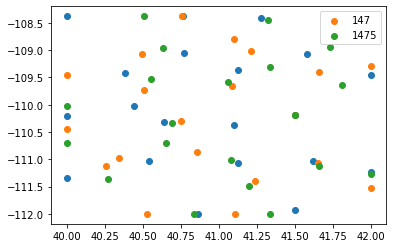

In [7]:
plt.scatter(sensors14[:,0],sensors14[:,1])
plt.scatter(sensors147[:,0],sensors147[:,1],label='147')
plt.scatter(sensors1475[:,0],sensors1475[:,1],label='1475')
plt.legend()

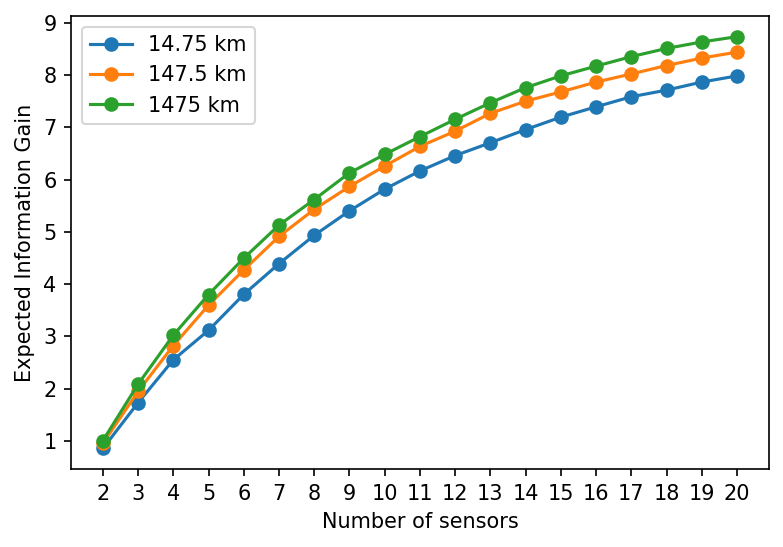

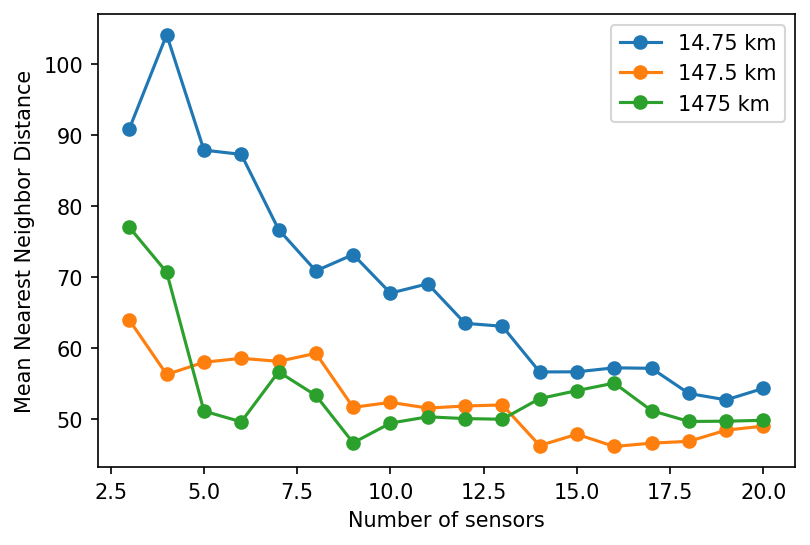

In [10]:
eigs14, igs14, dists14 = get_eig_nn('/gpfs/jpcalla/lscal_14',22,22)
eigs147, igs147, dists147 = get_eig_nn('/gpfs/jpcalla/lscal_147',22, 22)
eigs1475, igs1475, dists1475 = get_eig_nn('/gpfs/jpcalla/lscal_1475',22, 22)
# Store eigs from 3 different runs
        
# Plot eig by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(2,21),eigs14,marker='o', label='14.75 km')
plt.plot(np.arange(2,21),eigs147,marker='o', label='147.5 km')
plt.plot(np.arange(2,21),eigs1475,marker='o', label='1475 km')

plt.xlabel('Number of sensors')
plt.ylabel('Expected Information Gain')
plt.legend(loc='upper left')
plt.xticks(np.arange(2,21))
plt.savefig('corr_curves.pdf', dpi=300)
plt.show()

# Plot mean nearest neighbor distance by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(3,21),dists14,marker='o',label='14.75 km')
plt.plot(np.arange(3,21),dists147,marker='o', label='147.5 km')
plt.plot(np.arange(3,21),dists1475,marker='o', label='1475 km')

# plt.plot(np.arange(3,22),low_dists,marker='o', label='constant std of 10')
plt.xlabel('Number of sensors')
plt.ylabel('Mean Nearest Neighbor Distance')
plt.legend()
plt.savefig('corr_dists.pdf', dpi=300)
plt.show()

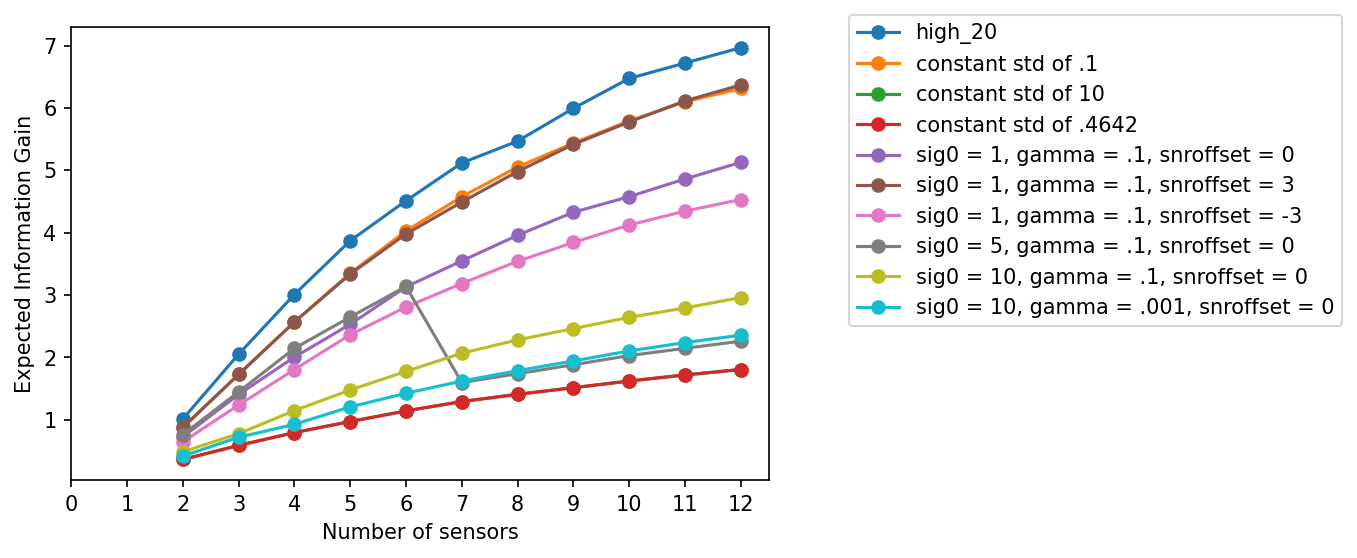

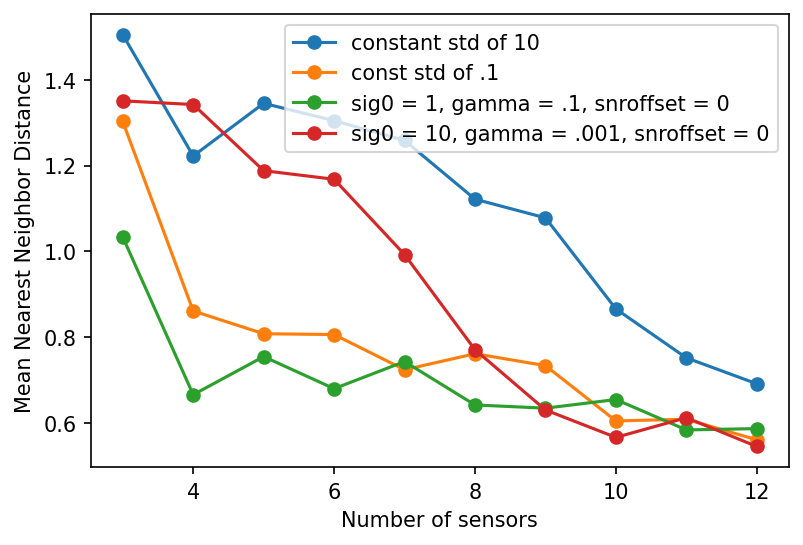

In [132]:
thomas_path = '/ascldap/users/tacatan/hpc_home/seismic_oed'
# Store eigs from 3 different runs
high20_eigs = []
nom20_eigs = []
low20_eigs = []
const_eigs = []
siggam_eigs = []
high_siggam_eigs = []
low_siggam_eigs = []
sig5_eigs = []
sig10_eigs = []
drop_eigs = []
gam001_eigs = []

high20_igs = []
nom20_igs = []
low20_igs = []
const_igs = []
siggam_igs = []
high_siggam_igs = []
low_siggam_igs= []
sig5_igs = []
sig10_igs = []
drop_igs = []
gam001_igs = []


# Store mean nearest neighbor distance from 3 different runs
high_dists = []
nom_dists = []
low_dists = []
const_dists = []
siggam_dists = []
high_siggam_dists = []
low_siggam_dists = []
sig5_dists = []
sig10_dists = []
drop_dists = []
gam001_dists =[]

for i in range(2,13):
    # High_20 run:
    res = np.load(f'high_20/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # store eig
    high20_igs.append(igs)
    high20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        high_dists.append(mean_dist)
 
    # Nominal_20 run:
    res = np.load(f'nominal_20_1_13/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    nom20_igs.append(igs)
    nom20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        nom_dists.append(mean_dist)
    
    # Low_20 run:
    res = np.load(f'low_20_1_18/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs)  # Store eig  
    low20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        low_dists.append(mean_dist)

    # Nominal_20 run:
    #res = np.load(f'const_462_0118/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    const_igs.append(igs)
    const_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        const_dists.append(mean_dist)
        
    # Nominal_20 run:
    res = np.load(f'sig1gamma0_0119/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    siggam_igs.append(igs)
    siggam_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        siggam_dists.append(mean_dist)
        
    # high w/ sigm0=1 and gamma=.1 run:
    res = np.load(f'high_sig1gam1/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    high_siggam_igs.append(igs)
    high_siggam_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        high_siggam_dists.append(mean_dist)
        
    # low w/ sigm0=1 and gamma=.1 run:
    res = np.load(f'low_sig1gam1/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    low_siggam_igs.append(igs)
    low_siggam_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        low_siggam_dists.append(mean_dist)
        
    # sig0=1 gamma=.1 snroffset=5:
    res = np.load(f'sig10/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    sig5_igs.append(igs)
    sig5_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        sig5_dists.append(mean_dist)
        
    # sig0=1 gamma=.1 snroffset=10:
    res = np.load(f'sig5/result_eigdata{i}.npz')
    igs = res['eigdata_full'][:,0]
    eig = np.max(igs) # Store eig
    sig10_igs.append(igs)
    sig10_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        sig10_dists.append(mean_dist)
        
    # sig0=1 gamma=.1 snroffset=10:
    if i <9:
        res = np.load(f'drop_test/result_eigdata{i}.npz')
        igs = res['eigdata_full'][:,0]
        eig = np.max(igs) # Store eig
        drop_igs.append(igs)
        drop_eigs.append(eig)

        # Calculate and store mean nearest neighbor distance when possible
        if i>2:
            locs = res['sensors'][:,:2]
            nn = NearestNeighbors().fit(locs)
            dists, _ = nn.kneighbors(locs,2)
            mean_dist = dists[:,1].mean()
            drop_dists.append(mean_dist)
    else:
        drop_igs.append(0)
        drop_eigs.append(0)


    # sig0=1 gamma=.1 snroffset=10:
    if i <13:
        res = np.load(f'gamma_001/result_eigdata{i}.npz')
        igs = res['eigdata_full'][:,0]
        eig = np.max(igs) # Store eig
        gam001_igs.append(igs)
        gam001_eigs.append(eig)

        # Calculate and store mean nearest neighbor distance when possible
        if i>2:
            locs = res['sensors'][:,:2]
            nn = NearestNeighbors().fit(locs)
            dists, _ = nn.kneighbors(locs,2)
            mean_dist = dists[:,1].mean()
            gam001_dists.append(mean_dist)
    else:
        gam001_igs.append(0)
        gam001_eigs.append(0)
        
# Plot eig by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(2,13),high20_eigs,marker='o', label='high_20')
plt.plot(np.arange(2,13),nom20_eigs,marker='o', label='constant std of .1')
plt.plot(np.arange(2,13),low20_eigs,marker='o', label='constant std of 10')
plt.plot(np.arange(2,13),const_eigs,marker='o', label='constant std of .4642')
plt.plot(np.arange(2,13),siggam_eigs,marker='o', label='sig0 = 1, gamma = .1, snroffset = 0')
plt.plot(np.arange(2,13),high_siggam_eigs,marker='o', label='sig0 = 1, gamma = .1, snroffset = 3')
plt.plot(np.arange(2,13),low_siggam_eigs,marker='o', label='sig0 = 1, gamma = .1, snroffset = -3')
plt.plot(np.arange(2,13),sig5_eigs,marker='o', label='sig0 = 5, gamma = .1, snroffset = 0')
plt.plot(np.arange(2,13),sig10_eigs,marker='o', label='sig0 = 10, gamma = .1, snroffset = 0')
plt.plot(np.arange(2,13),gam001_eigs,marker='o', label='sig0 = 10, gamma = .001, snroffset = 0')
# plt.plot(np.arange(2,13),drop_eigs,marker='o', label='sig0 = 10, gamma = .1, snroffset = 0 with restarts')
plt.xlabel('Number of sensors')
plt.ylabel('Expected Information Gain')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xticks(np.arange(13))
plt.show()

# Plot mean nearest neighbor distance by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(3,13),low_dists,marker='o', label='constant std of 10')
plt.plot(np.arange(3,13),nom_dists,marker='o', label='const std of .1')
plt.plot(np.arange(3,13),siggam_dists,marker='o', label='sig0 = 1, gamma = .1, snroffset = 0')
plt.plot(np.arange(3,13),gam001_dists,marker='o', label='sig0 = 10, gamma = .001, snroffset = 0')
#plt.plot(np.arange(3,13),low_dists,marker='o', label='constant std of 10')
plt.xlabel('Number of sensors')
plt.ylabel('Mean Nearest Neighbor Distance')
plt.legend()
plt.show()

In [42]:
import obspy.geodetics as gd
gd.degrees2kilometers(gd.locations2degrees(40,-112,42,-108.38))

376.43292820981509

In [136]:
res = np.load('/gpfs/jpcalla/fidopt_0/result_eigdata13.npz')
sensors_0 = res['sensors']

array([[  41.5       , -110.19      ,    0.        ,    2.        ,
           0.        ],
       [  41.04017592, -109.14763419,    0.        ,    2.        ,
           0.        ],
       [  40.55560219, -110.27079962,    0.        ,    2.        ,
           0.        ],
       [  41.01414456, -111.2173235 ,    0.        ,    2.        ,
           0.        ],
       [  40.41469838, -109.27407993,    0.        ,    2.        ,
           0.        ],
       [  40.41018249, -111.16120422,    0.        ,    2.        ,
           0.        ],
       [  41.3951864 , -109.91492038,    0.        ,    2.        ,
           0.        ],
       [  41.53749983, -112.        ,    0.        ,    2.        ,
           0.        ],
       [  41.56645993, -108.99069064,    0.        ,    2.        ,
           0.        ],
       [  41.73327014, -110.95062882,    0.        ,    2.        ,
           0.        ],
       [  40.96545589, -110.21898244,    0.        ,    2.        ,
           0

In [35]:
sensors = np.load('fidopt_-1_5/result_eigdata12.npz')['sensors']

In [36]:
np.array2string(sensors,separator=',',max_line_width=1000).replace('[','').replace('],','').replace(']','').replace(' ', '')


'41.5,-110.19,-1.5,2.,0.\n40.40699017,-109.92546862,-1.5,2.,0.\n40.43916156,-108.38,-1.5,2.,0.\n40.,-108.96915074,-1.5,2.,0.\n40.83462971,-109.84290478,-1.5,2.,0.\n40.13844703,-110.50076975,-1.5,2.,0.\n40.7609754,-109.36059137,-1.5,2.,0.\n42.,-110.1716757,-1.5,2.,0.\n41.10762472,-111.35619127,-1.5,2.,0.\n41.98105832,-108.75938737,-1.5,2.,0.\n41.65012613,-111.04724403,-1.5,2.,0.'

In [13]:
import os
fpath = 'gpfs/jpcalla/fidopt_2'
fname = 'test.py'
'hello ' + os.path.join(fpath, fname) + ' testing'

'hello gpfs/jpcalla/fidopt_2/test.py testing'

In [38]:
with open('fidopt_-1_5.dat', 'a') as f:
    f.write(np.array2string(sensors,separator=',',max_line_width=1000).replace('[','').replace('],','').replace(']','').replace(' ', ''))

In [22]:
!ls /gpfs/jpcalla

fidopt_0      fidopt_0_1475  fidopt_-1_5  final_fid_prior  stds
fidopt_0_14   fidopt_0_5     fidopt_2	  plotsnrs	   test
fidopt_0_147  fidopt_147     final_fid	  plotsnrs_prior


In [49]:
!ls fidopt_-1_5

1_5_net.npz	       input_runner_4-7.dat  opt_obj22.pkl
input_runner_0-0.dat   input_runner_5-0.dat  opt_obj2.pkl
input_runner_0-1.dat   input_runner_5-1.dat  opt_obj3.pkl
input_runner_0-2.dat   input_runner_5-2.dat  opt_obj4.pkl
input_runner_0-3.dat   input_runner_5-3.dat  opt_obj5.pkl
input_runner_0-4.dat   input_runner_5-4.dat  opt_obj6.pkl
input_runner_0-5.dat   input_runner_5-5.dat  opt_obj7.pkl
input_runner_0-6.dat   input_runner_5-6.dat  opt_obj8.pkl
input_runner_0-7.dat   input_runner_5-7.dat  opt_obj9.pkl
input_runner_10-0.dat  input_runner_6-0.dat  result10.pkl
input_runner_10-1.dat  input_runner_6-1.dat  result11.pkl
input_runner_10-2.dat  input_runner_6-2.dat  result12.pkl
input_runner_10-3.dat  input_runner_6-3.dat  result13.pkl
input_runner_10-4.dat  input_runner_6-4.dat  result14.pkl
input_runner_10-5.dat  input_runner_6-5.dat  result15.pkl
input_runner_10-6.dat  input_runner_6-6.dat  result16.pkl
input_runner_10-7.dat  input_runner_6-7.dat  result17.pkl
input_runner_1-0.

In [52]:
np.load('fidopt_-1_5/result_eigdata19.npz')['sensors']

array([[  41.5       , -110.19      ,   -1.5       ,    2.        ,
           0.        ],
       [  40.40699017, -109.92546862,   -1.5       ,    2.        ,
           0.        ],
       [  40.43916156, -108.38      ,   -1.5       ,    2.        ,
           0.        ],
       [  40.        , -108.96915074,   -1.5       ,    2.        ,
           0.        ],
       [  40.83462971, -109.84290478,   -1.5       ,    2.        ,
           0.        ],
       [  40.13844703, -110.50076975,   -1.5       ,    2.        ,
           0.        ],
       [  40.7609754 , -109.36059137,   -1.5       ,    2.        ,
           0.        ],
       [  42.        , -110.1716757 ,   -1.5       ,    2.        ,
           0.        ],
       [  41.10762472, -111.35619127,   -1.5       ,    2.        ,
           0.        ],
       [  41.98105832, -108.75938737,   -1.5       ,    2.        ,
           0.        ],
       [  41.65012613, -111.04724403,   -1.5       ,    2.        ,
           0

In [53]:
np.load('fidopt_-1_5/result_eigdata8.npz')['sensors']

array([[  41.5       , -110.19      ,   -1.5       ,    2.        ,
           0.        ],
       [  40.40699017, -109.92546862,   -1.5       ,    2.        ,
           0.        ],
       [  40.43916156, -108.38      ,   -1.5       ,    2.        ,
           0.        ],
       [  40.        , -108.96915074,   -1.5       ,    2.        ,
           0.        ],
       [  40.83462971, -109.84290478,   -1.5       ,    2.        ,
           0.        ],
       [  40.13844703, -110.50076975,   -1.5       ,    2.        ,
           0.        ],
       [  40.7609754 , -109.36059137,   -1.5       ,    2.        ,
           0.        ]])

In [8]:
for i in ['-1_5', '0', '0_5', '2']:
    num = i.strip('-')
    fpath = f'/gpfs/jpcalla/fidopt_{i}/{num}_net.npz'
    sensors = np.load(fpath)['sensors']

In [4]:
for i in range(12):
    print(i//4, i%4)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
